In [85]:
# Import some dependency modules that we are going to need to run the SSD model

import onnx
from onnx import numpy_helper
import numpy as np          
from ssd_deps import predict_pb2
from ssd_deps import onnx_ml_pb2
import requests
from PIL import Image
import urllib.request
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [86]:
# Download the model from model zoo

onnx_model_url = "https://onnxzoo.blob.core.windows.net/models/opset_10/ssd/ssd.onnx"
urllib.request.urlretrieve(onnx_model_url, filename="ssd.onnx")


('ssd.onnx', <http.client.HTTPMessage at 0x1d0832f5c50>)

In [88]:
# Start the ORT Runtime server
import os
PORT_NUMBER="8010" # Change this port number if getting errors like - port already allocated, etc.
cmd = "sudo docker run -v $(pwd):$(pwd) -e MODEL_ABSOLUTE_PATH=$(pwd)/ssd.onnx -p " + str(PORT_NUMBER) + ":8001 heshadri91/ortserver"
os.system(cmd)

1

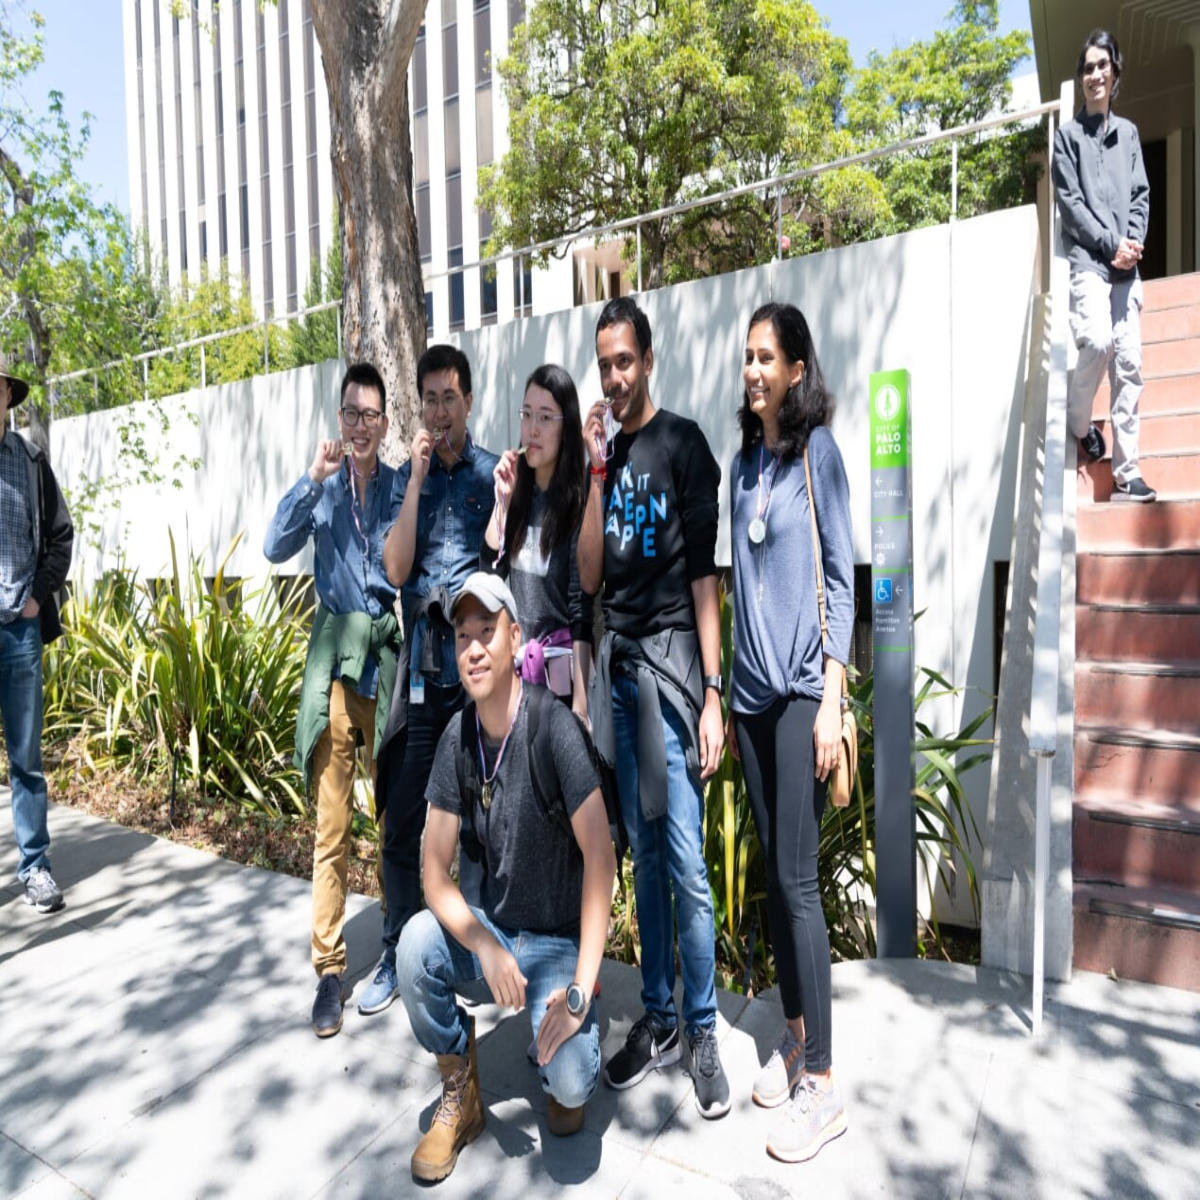

In [72]:
# Load the raw image

# Load the image
input_shape = (1, 3, 1200, 1200)
img = Image.open("images/team_event.jpg")
img = img.resize((1200, 1200), Image.BILINEAR)

# Let us see what the input image looks like
img

In [73]:
# Preprocess and normalize the image

img_data = np.array(img)
img_data = np.transpose(img_data, [2, 0, 1])
img_data = np.expand_dims(img_data, 0)
mean_vec = np.array([0.485, 0.456, 0.406])
stddev_vec = np.array([0.229, 0.224, 0.225])
norm_img_data = np.zeros(img_data.shape).astype('float32')
for i in range(img_data.shape[1]):
    norm_img_data[:,i,:,:] = (img_data[:,i,:,:]/255 - mean_vec[i]) / stddev_vec[i]

In [81]:
# Create request message to be sent to the ORT server

input_tensor = numpy_helper.from_array(norm_img_data)
request_message = predict_pb2.PredictRequest()
request_message.inputs["image"].data_type = input_tensor.data_type
request_message.inputs["image"].dims.extend(input_tensor.dims)
request_message.inputs["image"].raw_data = input_tensor.raw_data

content_type_headers = ['application/x-protobuf', 'application/octet-stream', 'application/vnd.google.protobuf']

for h in content_type_headers:
    request_headers = {
        'Content-Type': h,
        'Accept': 'application/x-protobuf'
    }

In [82]:
# Inference run using ORT server

inference_url = "http://127.0.0.1:" + PORT_NUMBER + "/v1/models/ssd/versions/1:predict"
response = requests.post(inference_url, headers=request_headers, data=request_message.SerializeToString())

In [83]:
# Parse response message

response_message = predict_pb2.PredictResponse()
response_message.ParseFromString(response.content)

bboxes = np.frombuffer(response_message.outputs['bboxes'].raw_data, dtype=np.float32)
labels = np.frombuffer(response_message.outputs['labels'].raw_data, dtype=np.int64)
scores = np.frombuffer(response_message.outputs['scores'].raw_data, dtype=np.float32)

print('Boxes shape:', response_message.outputs['bboxes'].dims)
print('Labels shape:', response_message.outputs['labels'].dims)
print('Scores shape:', response_message.outputs['scores'].dims)

Boxes shape: [1, 200, 4]
Labels shape: [1, 200]
Scores shape: [1, 200]


<Figure size 432x288 with 0 Axes>

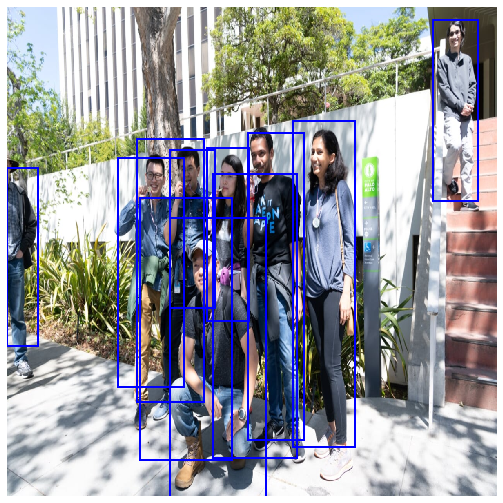

In [84]:
# Display image with bounding boxes

plt.figure()
fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(img)

resized_width = 1200  # we resized the original image, remember ? 
resized_height = 1200
num_boxes = 10 # we limit displaying to just 10 boxes to avoid clogging the result image with boxes
               # The results are already sorted based on box confidences, so we just pick top N boxes without sorting
    
for c in range(num_boxes + 1):    
    base_index = c * 4
    y1, x1, y2, x2 = bboxes[base_index] * resized_height, bboxes[base_index + 1] * resized_width, bboxes[base_index + 2] * resized_height, bboxes[base_index + 3] * resized_width 
    color = 'blue'
    box_h = (y2 - y1)
    box_w = (x2 - x1)
    bbox = patches.Rectangle((y1, x1), box_h, box_w, linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(bbox)

plt.axis('off')

# Save image
plt.savefig("result.jpg", bbox_inches='tight', pad_inches=0.0)
plt.show()
